## Otsu's Method

Evaluating segmentation on first 10 images of the MSFD/1 dataset...


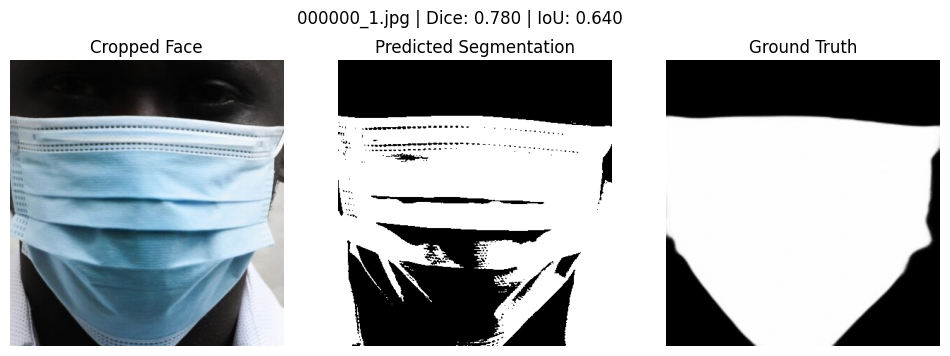

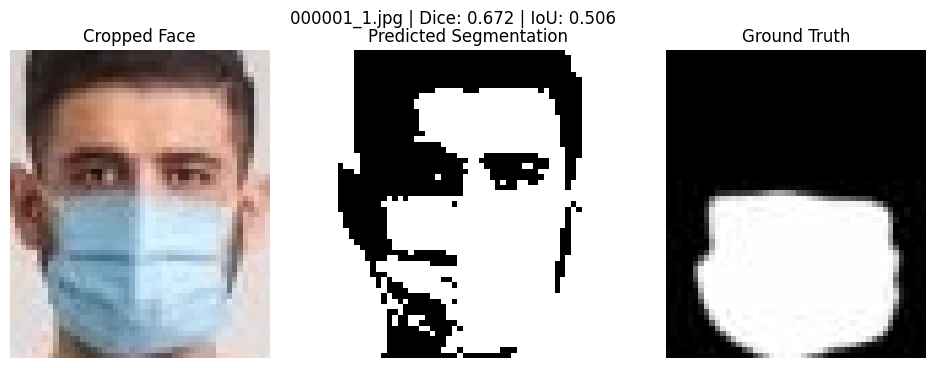

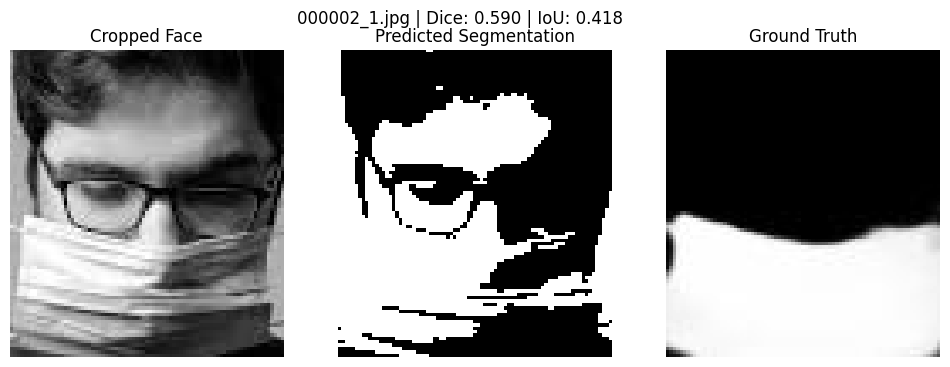

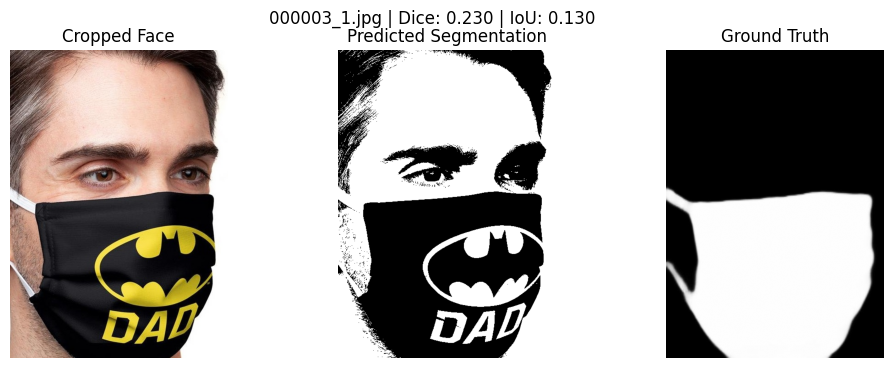

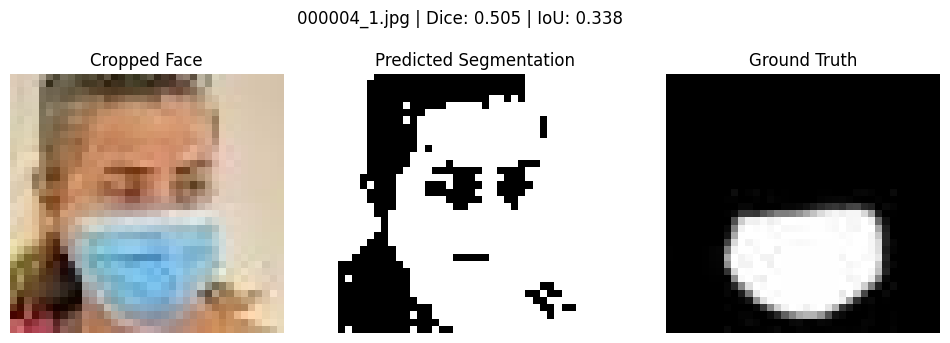

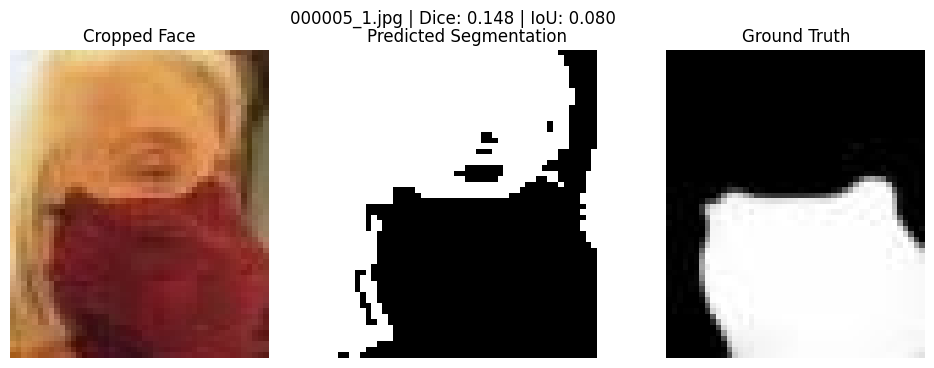

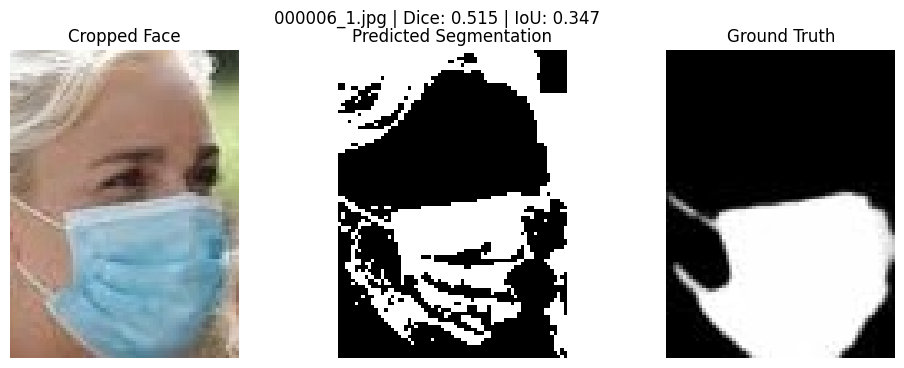

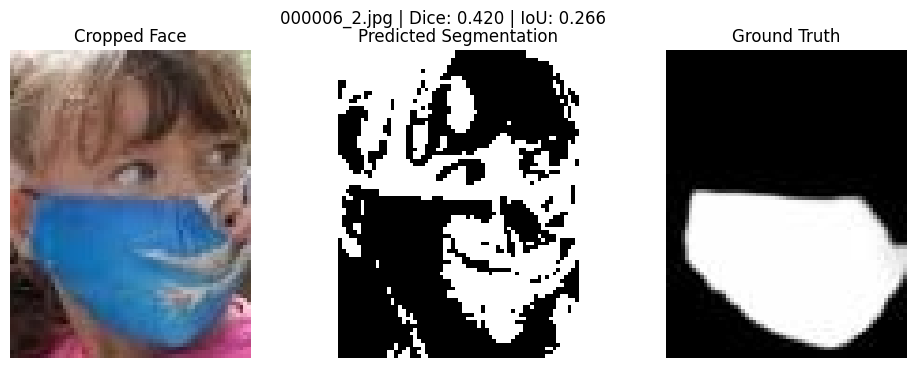

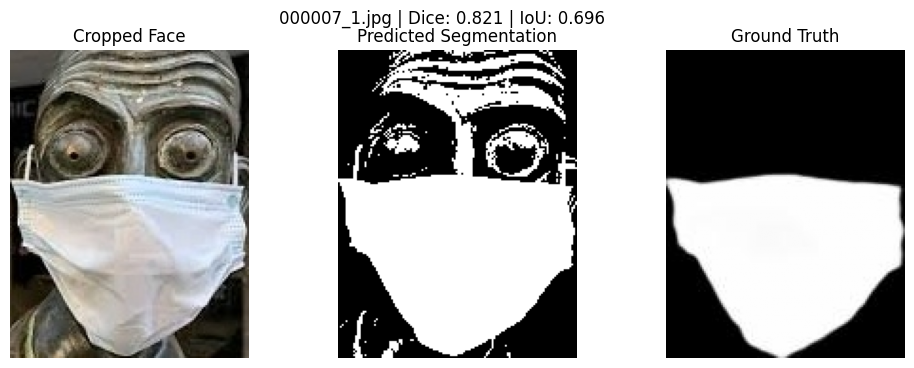

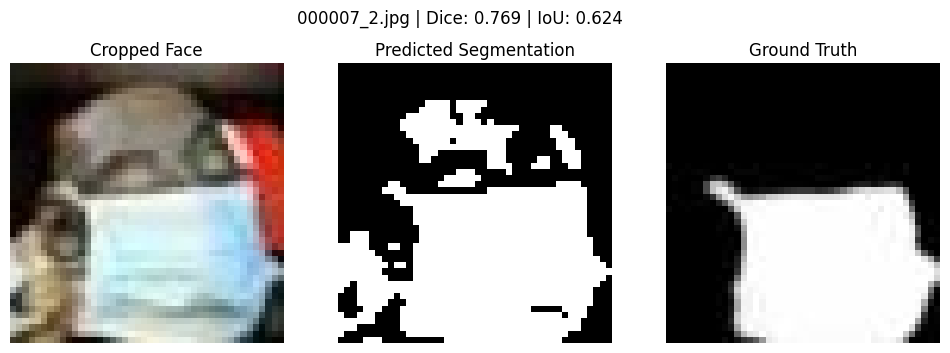

Average Dice Score (first 10 images): 0.545
Average IoU (first 10 images): 0.404

Predicting segmentation on new images from MSFD/2...
Saved prediction for 114827560_612637226347903_2763860821287827135_n.jpg
Saved prediction for 1234carlton_130217032_1269039916807375_8534704696144444690_n.jpg
Saved prediction for 129421898_393248228586637_4979851665036615942_n.jpg
Saved prediction for 131556639_125546539680466_2522064222681575030_n.jpg
Saved prediction for 144083471_420353002379656_3196599189209606771_n.jpg
Saved prediction for 144169341_424281655295619_985180884240761776_n.jpg
Saved prediction for 167593808_168567418448665_2098665313705176703_n.jpg
Saved prediction for 168622105_126656466144105_3969694588148735060_n.jpg
Saved prediction for 169596341_367741371081945_6135787147079577476_n.jpg
Saved prediction for 172960202_140502171294523_7286329741002228456_n.jpg


In [1]:
import os
import cv2
import numpy as np
import glob
import matplotlib.pyplot as plt

# Define paths (modify if needed)
msfd1_folder = "MSFD/1"
img_folder = os.path.join(msfd1_folder, "img")
face_crop_folder = os.path.join(msfd1_folder, "face_crop")
# Output segmentation for evaluation (this is our predicted result for MSFD/1)
face_crop_segmentation_folder = os.path.join(msfd1_folder, "face_crop_segmentation_Otsu_pred")
# Ground truth segmentation folder
gt_segmentation_folder = os.path.join(msfd1_folder, "face_crop_segmentation")

msfd2_folder = "MSFD/2"
msfd2_img_folder = os.path.join(msfd2_folder, "img")
msfd2_predictions_folder = os.path.join(msfd2_folder, "predictions_Otsu")

# Create output directories if they do not exist
os.makedirs(face_crop_segmentation_folder, exist_ok=True)
os.makedirs(msfd2_predictions_folder, exist_ok=True)

def otsu_segmentation(image):
    """
    Apply Otsu's thresholding for segmentation.
    Expects a grayscale image. If input is color, converts it to grayscale.
    Returns a binary image.
    """
    if len(image.shape) == 3:
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    else:
        gray = image
    _, binary = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    return binary

def compute_metrics(pred, gt):
    """
    Compute Dice Score and Intersection over Union (IoU) between two binary masks.
    The masks should be binary (0 and 255). We convert them to 0 and 1.
    """
    pred_bin = (pred > 0).astype(np.uint8)
    gt_bin = (gt > 0).astype(np.uint8)
    
    intersection = np.sum(pred_bin * gt_bin)
    union = np.sum(pred_bin) + np.sum(gt_bin)
    
    dice = (2. * intersection) / union if union > 0 else 1.0
    
    iou_union = np.sum(pred_bin) + np.sum(gt_bin) - intersection
    iou = intersection / iou_union if iou_union > 0 else 1.0
    return dice, iou

def evaluate_segmentation():
    """
    Loop over the first 10 face_crop images, apply segmentation, save the predicted segmentation,
    and compute evaluation metrics against the ground truth masks.
    """
    dice_scores = []
    iou_scores = []
    
    face_crop_images = sorted(glob.glob(os.path.join(face_crop_folder, "*")))
    # Limit to the first 10 images
    face_crop_images = face_crop_images[:10]
    
    for face_crop_path in face_crop_images:
        filename = os.path.basename(face_crop_path)
        img = cv2.imread(face_crop_path)
        if img is None:
            print(f"Error reading {face_crop_path}")
            continue
        
        seg = otsu_segmentation(img)
        out_path = os.path.join(face_crop_segmentation_folder, filename)
        cv2.imwrite(out_path, seg)
        
        gt_path = os.path.join(gt_segmentation_folder, filename)
        gt = cv2.imread(gt_path, cv2.IMREAD_GRAYSCALE)
        if gt is None:
            print(f"Ground truth for {filename} not found, skipping evaluation.")
            continue
        
        if seg.shape != gt.shape:
            seg = cv2.resize(seg, (gt.shape[1], gt.shape[0]))
        
        dice, iou = compute_metrics(seg, gt)
        dice_scores.append(dice)
        iou_scores.append(iou)
        
        # Optionally visualize a few results
        plt.figure(figsize=(12, 4))
        plt.subplot(1, 3, 1)
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        plt.title("Cropped Face")
        plt.axis("off")
        
        plt.subplot(1, 3, 2)
        plt.imshow(seg, cmap="gray")
        plt.title("Predicted Segmentation")
        plt.axis("off")
        
        plt.subplot(1, 3, 3)
        plt.imshow(gt, cmap="gray")
        plt.title("Ground Truth")
        plt.axis("off")
        
        plt.suptitle(f"{filename} | Dice: {dice:.3f} | IoU: {iou:.3f}")
        plt.show() 
    
    if dice_scores and iou_scores:
        avg_dice = np.mean(dice_scores)
        avg_iou = np.mean(iou_scores)
        print(f"Average Dice Score (first 10 images): {avg_dice:.3f}")
        print(f"Average IoU (first 10 images): {avg_iou:.3f}")
    else:
        print("No valid images for evaluation.")

def predict_new_images():
    """
    Process the first 10 images from MSFD/2/img using Otsu segmentation and
    save the predicted segmentation in MSFD/2/predictions.
    """
    img_paths = sorted(glob.glob(os.path.join(msfd2_img_folder, "*")))
    selected_paths = img_paths[:10]
    
    for img_path in selected_paths:
        filename = os.path.basename(img_path)
        img = cv2.imread(img_path)
        if img is None:
            print(f"Error reading {img_path}")
            continue
        
        seg = otsu_segmentation(img)
        out_path = os.path.join(msfd2_predictions_folder, filename)
        cv2.imwrite(out_path, seg)
        print(f"Saved prediction for {filename}")

if __name__ == "__main__":
    print("Evaluating segmentation on first 10 images of the MSFD/1 dataset...")
    evaluate_segmentation()
    
    print("\nPredicting segmentation on new images from MSFD/2...")
    predict_new_images()


## Region Growing

Evaluating Region Growing segmentation on 10 images from the MSFD/1 dataset...


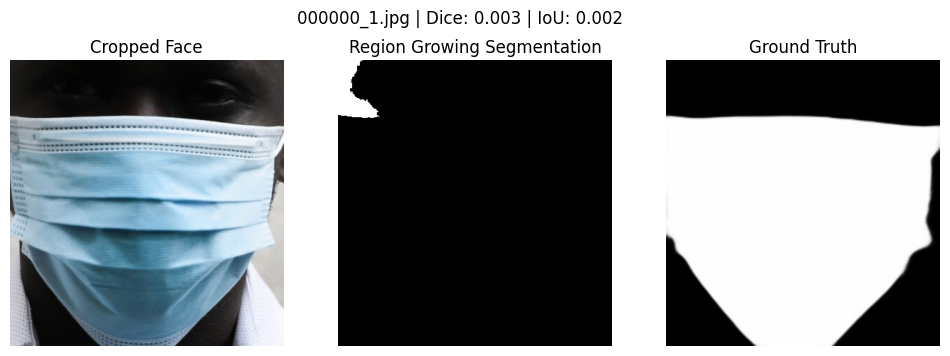

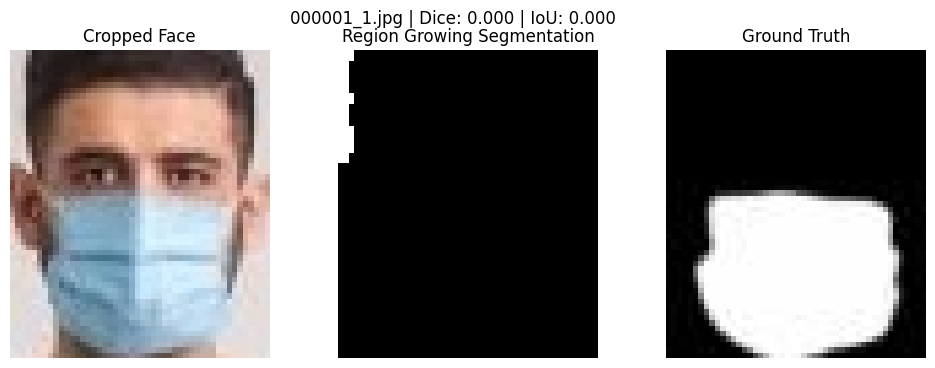

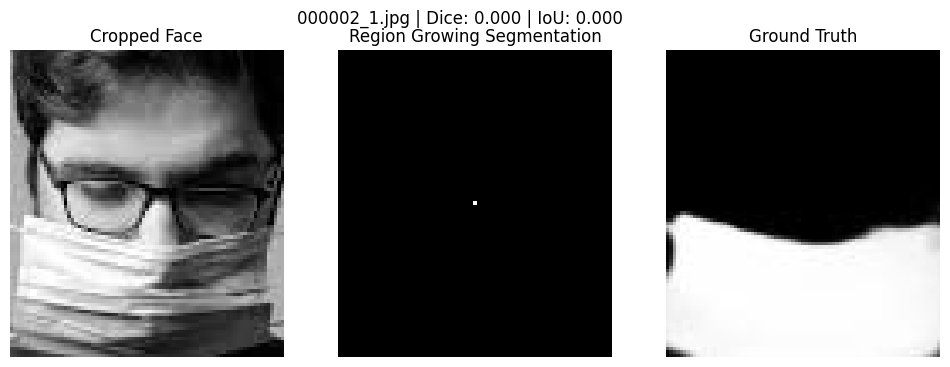

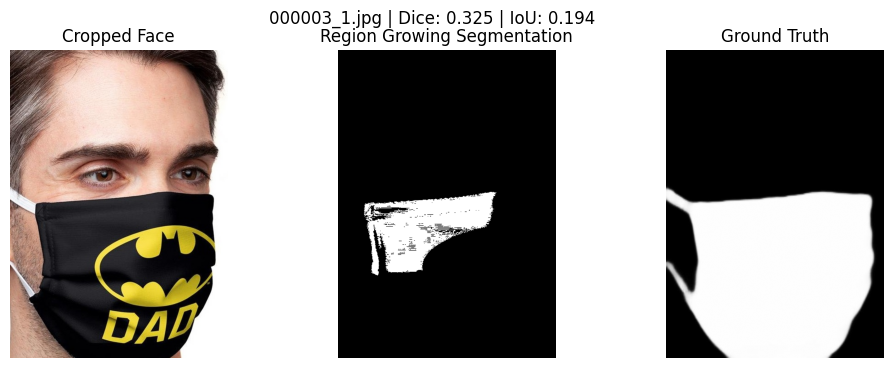

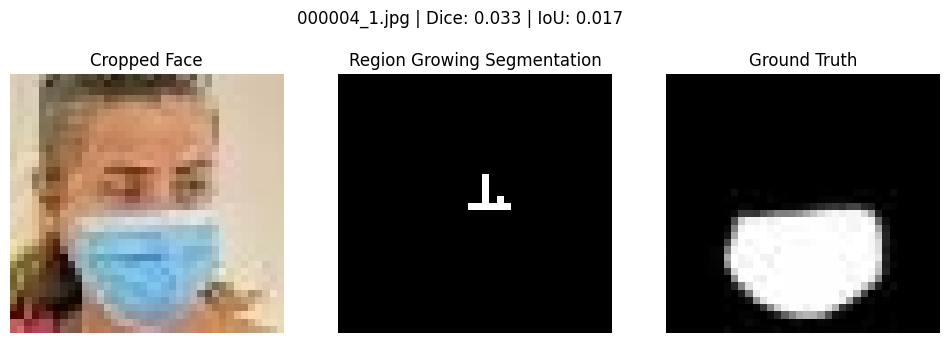

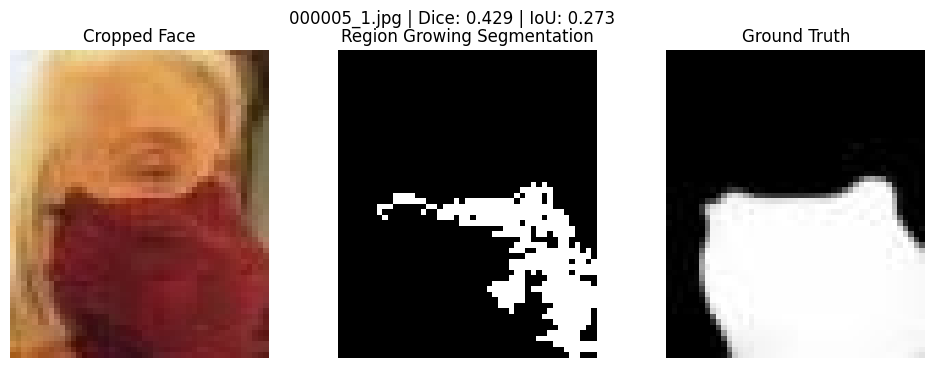

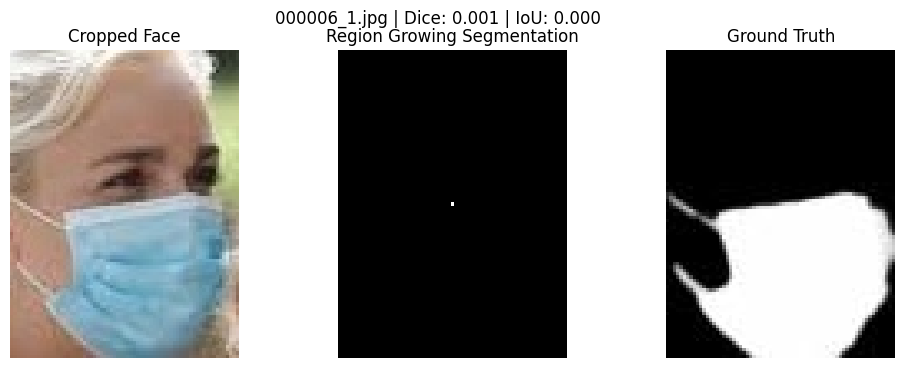

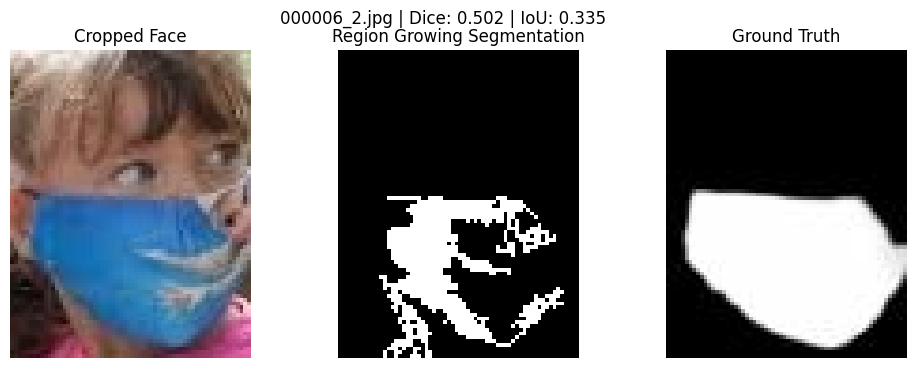

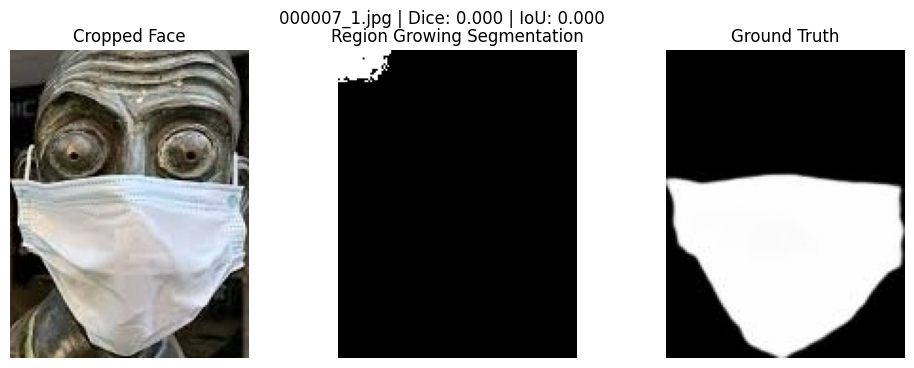

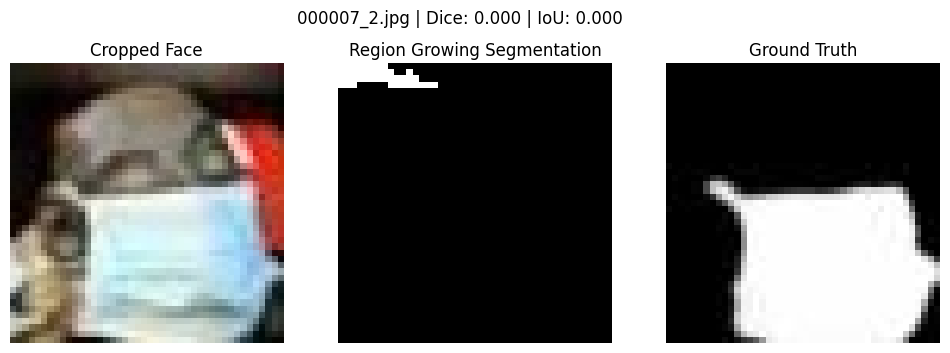

Average Dice Score (first 10 images): 0.129
Average IoU (first 10 images): 0.082

Predicting segmentation on 10 new images from MSFD/2 using Region Growing...
Saved prediction for 114827560_612637226347903_2763860821287827135_n.jpg
Saved prediction for 1234carlton_130217032_1269039916807375_8534704696144444690_n.jpg
Saved prediction for 129421898_393248228586637_4979851665036615942_n.jpg
Saved prediction for 131556639_125546539680466_2522064222681575030_n.jpg
Saved prediction for 144083471_420353002379656_3196599189209606771_n.jpg
Saved prediction for 144169341_424281655295619_985180884240761776_n.jpg
Saved prediction for 167593808_168567418448665_2098665313705176703_n.jpg
Saved prediction for 168622105_126656466144105_3969694588148735060_n.jpg
Saved prediction for 169596341_367741371081945_6135787147079577476_n.jpg
Saved prediction for 172960202_140502171294523_7286329741002228456_n.jpg


In [4]:
import os
import cv2
import numpy as np
import glob
import matplotlib.pyplot as plt

# Define paths (modify if needed)
msfd1_folder = "MSFD/1"
img_folder = os.path.join(msfd1_folder, "img")
face_crop_folder = os.path.join(msfd1_folder, "face_crop")
# Output segmentation for evaluation (predicted results for MSFD/1 using Region Growing with dual seeds)
face_crop_segmentation_folder = os.path.join(msfd1_folder, "face_crop_segmentation_regiongrowing_pred")
# Ground truth segmentation folder
gt_segmentation_folder = os.path.join(msfd1_folder, "face_crop_segmentation")

msfd2_folder = "MSFD/2"
msfd2_img_folder = os.path.join(msfd2_folder, "img")
# Predictions folder for MSFD/2 with method name in folder
msfd2_predictions_folder = os.path.join(msfd2_folder, "predictions_regiongrowing")

# Create output directories if they do not exist
os.makedirs(face_crop_segmentation_folder, exist_ok=True)
os.makedirs(msfd2_predictions_folder, exist_ok=True)

def region_growing_segmentation(image, threshold=10):
    """
    Apply multi-seed Region Growing segmentation to the input image.
    Two seeds are used:
      - Seed 1: center pixel (assumed to belong to the mask)
      - Seed 2: top-left pixel (assumed background)
    The algorithm grows regions from both seeds using 8-connected neighbors.
    After region growing, the region (label) with the lower average intensity 
    (assumed to be the mask) is chosen.
    
    Parameters:
      image    : Input image (color or grayscale).
      threshold: Maximum allowed intensity difference for region inclusion.
    
    Returns:
      A binary mask (uint8) where the segmented region is 255 and the background is 0.
    """
    # Convert image to grayscale if needed
    if len(image.shape) == 3:
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    else:
        gray = image.copy()
    
    h, w = gray.shape
    # Initialize label image with -1 (unlabeled)
    labels = -1 * np.ones((h, w), dtype=np.int32)
    
    # Define seeds:
    seed1 = (h // 2, w // 2)  # center pixel
    seed2 = (0, 0)            # top-left corner
    
    # Assign labels: 1 for seed1, 2 for seed2.
    labels[seed1] = 1
    labels[seed2] = 2
    
    # Initialize queue with both seeds; each element is (x, y, label, seed_intensity)
    queue = [(seed1[0], seed1[1], 1, int(gray[seed1])),
             (seed2[0], seed2[1], 2, int(gray[seed2]))]
    
    # 8-connected neighbors offsets
    offsets = [(-1, -1), (-1, 0), (-1, 1),
               (0, -1),          (0, 1),
               (1, -1),  (1, 0), (1, 1)]
    
    while queue:
        x, y, label, seed_intensity = queue.pop(0)
        for dx, dy in offsets:
            nx, ny = x + dx, y + dy
            if nx < 0 or nx >= h or ny < 0 or ny >= w:
                continue
            if labels[nx, ny] != -1:
                continue
            # Include neighbor if its intensity difference with the seed is within threshold
            if abs(int(gray[nx, ny]) - seed_intensity) <= threshold:
                labels[nx, ny] = label
                queue.append((nx, ny, label, seed_intensity))
    
    # Compute average intensity for each region
    region1 = (labels == 1)
    region2 = (labels == 2)
    if np.sum(region1) == 0 or np.sum(region2) == 0:
        mask_label = 1  # default to region 1 if one region is empty
    else:
        mean1 = np.mean(gray[region1])
        mean2 = np.mean(gray[region2])
        # Assume the mask region has lower average intensity
        mask_label = 1 if mean1 < mean2 else 2
    
    binary_mask = np.uint8((labels == mask_label) * 255)
    return binary_mask

def compute_metrics(pred, gt):
    """
    Compute Dice Score and Intersection over Union (IoU) between two binary masks.
    Masks are expected to be in 0-255 format and are converted to binary (0 and 1).
    """
    pred_bin = (pred > 0).astype(np.uint8)
    gt_bin = (gt > 0).astype(np.uint8)
    
    intersection = np.sum(pred_bin * gt_bin)
    union = np.sum(pred_bin) + np.sum(gt_bin)
    
    dice = (2. * intersection) / union if union > 0 else 1.0
    iou_union = np.sum(pred_bin) + np.sum(gt_bin) - intersection
    iou = intersection / iou_union if iou_union > 0 else 1.0
    return dice, iou

def evaluate_segmentation():
    """
    Process the first 10 face_crop images from MSFD/1, apply Region Growing segmentation,
    save the predicted segmentation, compute evaluation metrics against the ground truth,
    and visualize the results.
    """
    dice_scores = []
    iou_scores = []
    
    face_crop_images = sorted(glob.glob(os.path.join(face_crop_folder, "*")))[:10]
    
    for face_crop_path in face_crop_images:
        filename = os.path.basename(face_crop_path)
        img = cv2.imread(face_crop_path)
        if img is None:
            print(f"Error reading {face_crop_path}")
            continue
        
        seg = region_growing_segmentation(img, threshold=10)
        out_path = os.path.join(face_crop_segmentation_folder, filename)
        cv2.imwrite(out_path, seg)
        
        gt_path = os.path.join(gt_segmentation_folder, filename)
        gt = cv2.imread(gt_path, cv2.IMREAD_GRAYSCALE)
        if gt is None:
            print(f"Ground truth for {filename} not found, skipping evaluation.")
            continue
        
        if seg.shape != gt.shape:
            seg = cv2.resize(seg, (gt.shape[1], gt.shape[0]))
        
        dice, iou = compute_metrics(seg, gt)
        dice_scores.append(dice)
        iou_scores.append(iou)
        
        # Visualize results
        plt.figure(figsize=(12, 4))
        plt.subplot(1, 3, 1)
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        plt.title("Cropped Face")
        plt.axis("off")
        
        plt.subplot(1, 3, 2)
        plt.imshow(seg, cmap="gray")
        plt.title("Region Growing Segmentation")
        plt.axis("off")
        
        plt.subplot(1, 3, 3)
        plt.imshow(gt, cmap="gray")
        plt.title("Ground Truth")
        plt.axis("off")
        
        plt.suptitle(f"{filename} | Dice: {dice:.3f} | IoU: {iou:.3f}")
        plt.show()
    
    if dice_scores and iou_scores:
        avg_dice = np.mean(dice_scores)
        avg_iou = np.mean(iou_scores)
        print(f"Average Dice Score (first 10 images): {avg_dice:.3f}")
        print(f"Average IoU (first 10 images): {avg_iou:.3f}")
    else:
        print("No valid images for evaluation.")

def predict_new_images():
    """
    Process the first 10 images from MSFD/2/img using Region Growing segmentation
    and save the predicted segmentation in the MSFD/2/predictions_regiongrowing folder.
    """
    img_paths = sorted(glob.glob(os.path.join(msfd2_img_folder, "*")))[:10]
    
    for img_path in img_paths:
        filename = os.path.basename(img_path)
        img = cv2.imread(img_path)
        if img is None:
            print(f"Error reading {img_path}")
            continue
        
        seg = region_growing_segmentation(img, threshold=10)
        out_path = os.path.join(msfd2_predictions_folder, filename)
        cv2.imwrite(out_path, seg)
        print(f"Saved prediction for {filename}")

if __name__ == "__main__":
    print("Evaluating Region Growing segmentation on 10 images from the MSFD/1 dataset...")
    evaluate_segmentation()
    
    print("\nPredicting segmentation on 10 new images from MSFD/2 using Region Growing...")
    predict_new_images()


## Clustering Segementation

Evaluating K-means segmentation on 10 images from the MSFD/1 dataset...


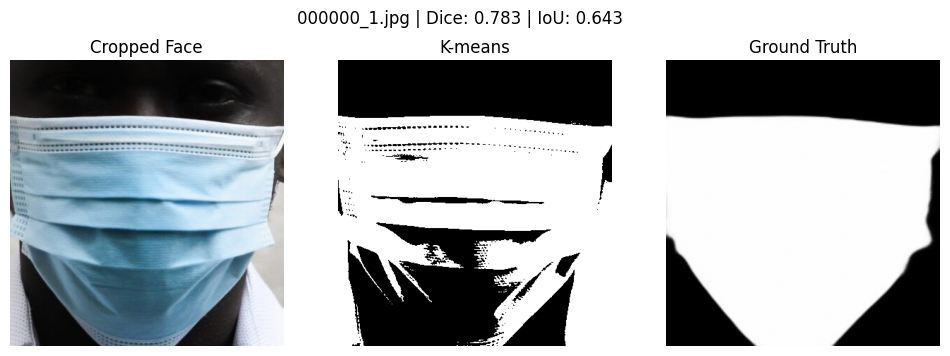

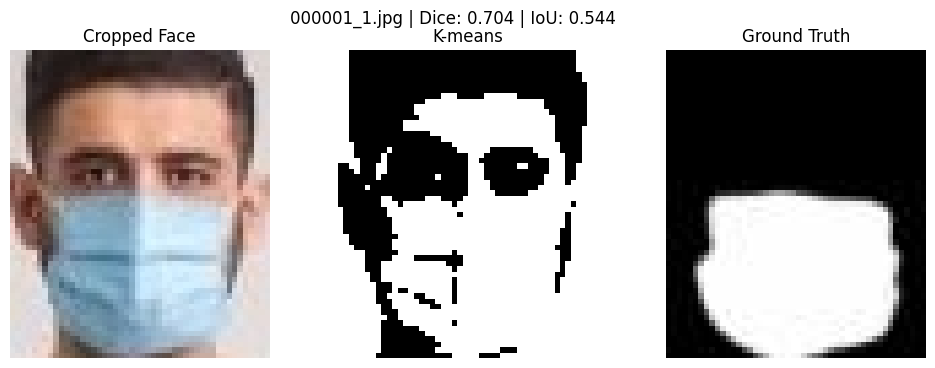

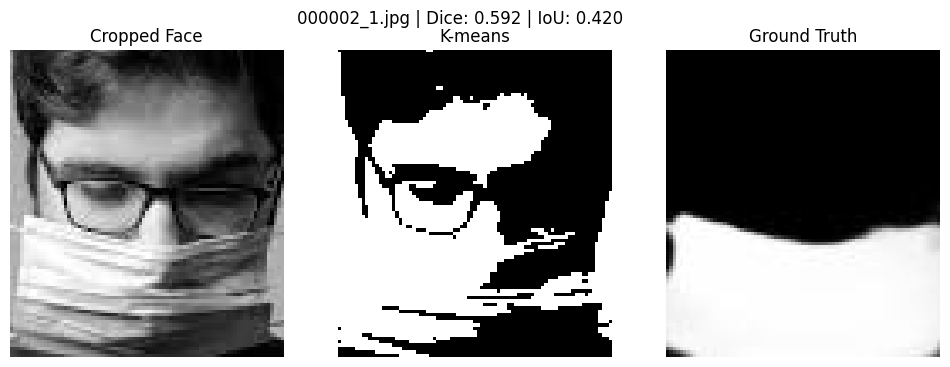

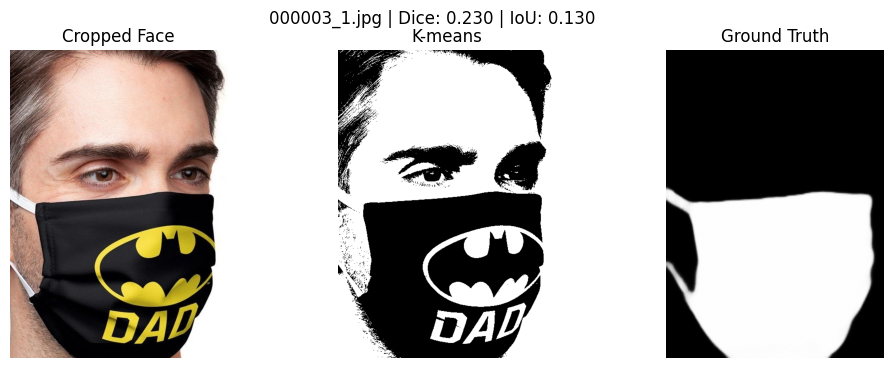

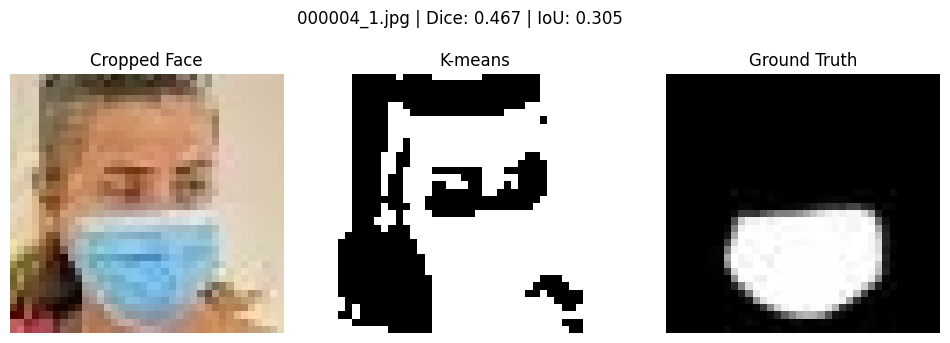

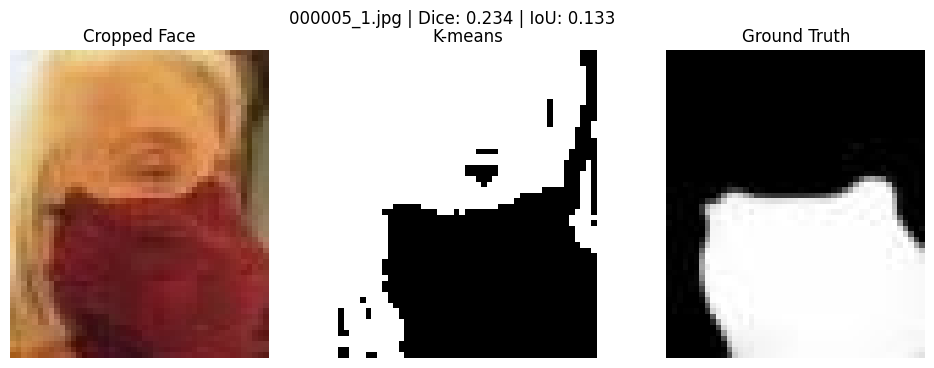

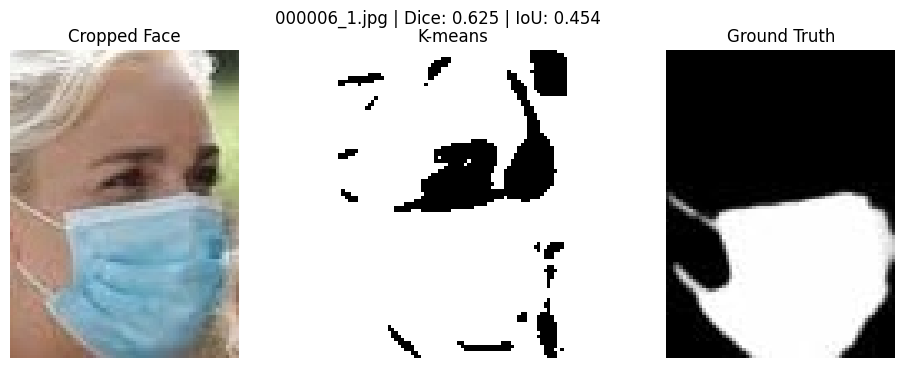

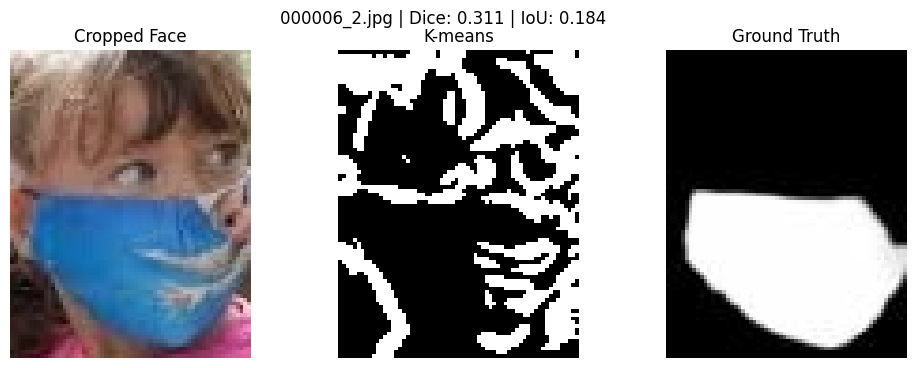

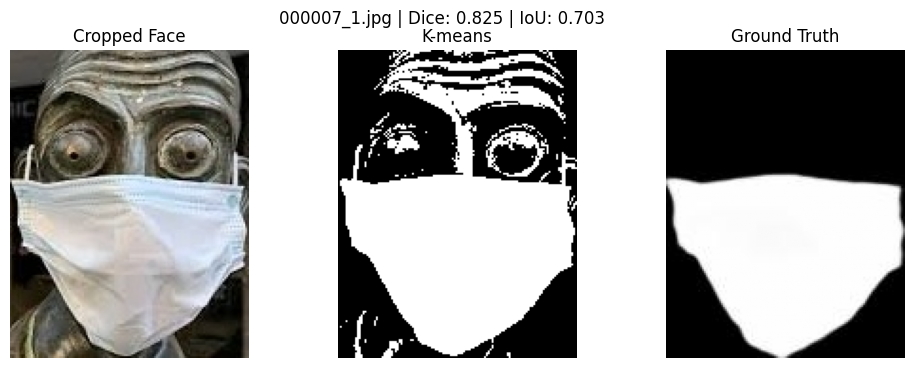

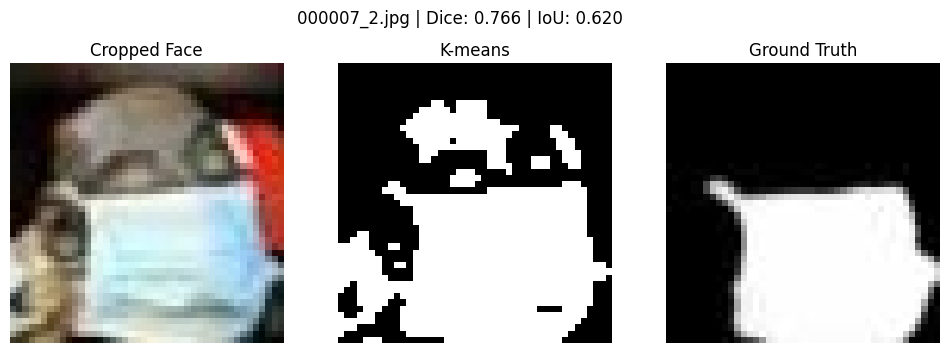

Average Dice Score (first 10 images): 0.554
Average IoU (first 10 images): 0.414

Predicting segmentation on 10 new images from MSFD/2 using K-means segmentation...
Saved prediction for 114827560_612637226347903_2763860821287827135_n.jpg
Saved prediction for 1234carlton_130217032_1269039916807375_8534704696144444690_n.jpg
Saved prediction for 129421898_393248228586637_4979851665036615942_n.jpg
Saved prediction for 131556639_125546539680466_2522064222681575030_n.jpg
Saved prediction for 144083471_420353002379656_3196599189209606771_n.jpg
Saved prediction for 144169341_424281655295619_985180884240761776_n.jpg
Saved prediction for 167593808_168567418448665_2098665313705176703_n.jpg
Saved prediction for 168622105_126656466144105_3969694588148735060_n.jpg
Saved prediction for 169596341_367741371081945_6135787147079577476_n.jpg
Saved prediction for 172960202_140502171294523_7286329741002228456_n.jpg


In [5]:
import os
import cv2
import numpy as np
import glob
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# Define paths (modify if needed)
msfd1_folder = "MSFD/1"
img_folder = os.path.join(msfd1_folder, "img")
face_crop_folder = os.path.join(msfd1_folder, "face_crop")
# Output segmentation for evaluation (predicted results for MSFD/1 using K-means with manual seeds)
face_crop_segmentation_folder = os.path.join(msfd1_folder, "face_crop_segmentation_kmeans_pred")
# Ground truth segmentation folder
gt_segmentation_folder = os.path.join(msfd1_folder, "face_crop_segmentation")

msfd2_folder = "MSFD/2"
msfd2_img_folder = os.path.join(msfd2_folder, "img")
# Predictions folder for MSFD/2 with method name in folder
msfd2_predictions_folder = os.path.join(msfd2_folder, "predictions_kmeans")

# Create output directories if they do not exist
os.makedirs(face_crop_segmentation_folder, exist_ok=True)
os.makedirs(msfd2_predictions_folder, exist_ok=True)

def kmeans_segmentation(image, K=2):
    """
    Apply K-means clustering segmentation to the input image using manual seeds.
    The segmentation is based on a feature vector for each pixel consisting of:
       - Intensity (gray)
       - Normalized x-coordinate
       - Normalized y-coordinate
       - Gradient magnitude
    The manual seeds are chosen as the center pixel (assumed mask) and the top-left pixel (assumed background).
    For K=2, the cluster with lower average intensity is assumed to be the mask region.
    
    Parameters:
      image : Input image (color or grayscale).
      K     : Number of clusters (default is 2).
      
    Returns:
      A binary mask (uint8) where the segmented region is 255 and the background is 0.
    """
    # Convert image to RGB (if needed) and then to grayscale
    if len(image.shape) == 3:
        rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    else:
        rgb = image.copy()
    gray = cv2.cvtColor(rgb, cv2.COLOR_RGB2GRAY)
    
    # Apply Gaussian blur
    blurred = cv2.GaussianBlur(gray, (5, 5), 8)
    
    # Compute gradient magnitude using Sobel operators
    sobelx = cv2.Sobel(blurred, cv2.CV_64F, 1, 0, ksize=5)
    sobely = cv2.Sobel(blurred, cv2.CV_64F, 0, 1, ksize=5)
    gradient = np.sqrt(sobelx**2 + sobely**2)
    gradient = cv2.normalize(gradient, None, 0, 255, cv2.NORM_MINMAX)
    
    # Build feature vector for each pixel: [intensity, x_norm, y_norm, gradient]
    height, width = gray.shape
    features = []
    for y in range(height):
        for x in range(width):
            features.append([gray[y, x], x / width, y / height, gradient[y, x]])
    features = np.array(features, dtype=np.float32)
    
    # Manual Seed Selection:
    # Seed 1: center pixel (assumed to be part of the mask)
    center_x, center_y = width // 2, height // 2
    seed1 = [gray[center_y, center_x], center_x / width, center_y / height, gradient[center_y, center_x]]
    # Seed 2: top-left corner (assumed background)
    seed2 = [gray[0, 0], 0, 0, gradient[0, 0]]
    init_centers = np.array([seed1, seed2], dtype=np.float32)
    
    # Apply K-means with manual seeds
    kmeans = KMeans(n_clusters=K, init=init_centers, n_init=1, max_iter=100, random_state=42)
    labels = kmeans.fit_predict(features)
    labels = labels.reshape((height, width))
    
    # Decide which cluster is the mask: assume lower average intensity corresponds to mask
    cluster0_mean = np.mean(features[labels.flatten() == 0, 0])
    cluster1_mean = np.mean(features[labels.flatten() == 1, 0])
    if cluster0_mean > cluster1_mean:
        labels = 1 - labels  # Swap labels
    
    binary_mask = (labels == 1).astype(np.uint8) * 255
    return binary_mask

def compute_metrics(pred, gt):
    """
    Compute Dice Score and Intersection over Union (IoU) between two binary masks.
    Both masks are expected to be in 0-255 format; they are converted to binary (0 and 1).
    """
    pred_bin = (pred > 0).astype(np.uint8)
    gt_bin = (gt > 0).astype(np.uint8)
    
    intersection = np.sum(pred_bin * gt_bin)
    union = np.sum(pred_bin) + np.sum(gt_bin)
    
    dice = (2. * intersection) / union if union > 0 else 1.0
    
    iou_union = np.sum(pred_bin) + np.sum(gt_bin) - intersection
    iou = intersection / iou_union if iou_union > 0 else 1.0
    return dice, iou

def evaluate_segmentation():
    """
    Process the first 10 face_crop images, apply K-means segmentation,
    save the predicted segmentation, compute evaluation metrics against the ground truth masks,
    and visualize the results.
    """
    dice_scores = []
    iou_scores = []
    
    face_crop_images = sorted(glob.glob(os.path.join(face_crop_folder, "*")))[:10]
    
    for face_crop_path in face_crop_images:
        filename = os.path.basename(face_crop_path)
        img = cv2.imread(face_crop_path)
        if img is None:
            print(f"Error reading {face_crop_path}")
            continue
        
        seg = kmeans_segmentation(img, K=2)
        out_path = os.path.join(face_crop_segmentation_folder, filename)
        cv2.imwrite(out_path, seg)
        
        gt_path = os.path.join(gt_segmentation_folder, filename)
        gt = cv2.imread(gt_path, cv2.IMREAD_GRAYSCALE)
        if gt is None:
            print(f"Ground truth for {filename} not found, skipping evaluation.")
            continue
        
        if seg.shape != gt.shape:
            seg = cv2.resize(seg, (gt.shape[1], gt.shape[0]))
        
        dice, iou = compute_metrics(seg, gt)
        dice_scores.append(dice)
        iou_scores.append(iou)
        
        # Visualize the results
        plt.figure(figsize=(12, 4))
        plt.subplot(1, 3, 1)
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        plt.title("Cropped Face")
        plt.axis("off")
        
        plt.subplot(1, 3, 2)
        plt.imshow(seg, cmap="gray")
        plt.title("K-means")
        plt.axis("off")
        
        plt.subplot(1, 3, 3)
        plt.imshow(gt, cmap="gray")
        plt.title("Ground Truth")
        plt.axis("off")
        
        plt.suptitle(f"{filename} | Dice: {dice:.3f} | IoU: {iou:.3f}")
        plt.show()
    
    if dice_scores and iou_scores:
        avg_dice = np.mean(dice_scores)
        avg_iou = np.mean(iou_scores)
        print(f"Average Dice Score (first 10 images): {avg_dice:.3f}")
        print(f"Average IoU (first 10 images): {avg_iou:.3f}")
    else:
        print("No valid images for evaluation.")

def predict_new_images():
    """
    Process the first 10 images from MSFD/2/img using K-means segmentation
    and save the predicted segmentation in the MSFD/2/predictions_kmeans folder.
    """
    img_paths = sorted(glob.glob(os.path.join(msfd2_img_folder, "*")))[:10]
    
    for img_path in img_paths:
        filename = os.path.basename(img_path)
        img = cv2.imread(img_path)
        if img is None:
            print(f"Error reading {img_path}")
            continue
        
        seg = kmeans_segmentation(img, K=2)
        out_path = os.path.join(msfd2_predictions_folder, filename)
        cv2.imwrite(out_path, seg)
        print(f"Saved prediction for {filename}")

if __name__ == "__main__":
    print("Evaluating K-means segmentation on 10 images from the MSFD/1 dataset...")
    evaluate_segmentation()
    
    print("\nPredicting segmentation on 10 new images from MSFD/2 using K-means segmentation...")
    predict_new_images()
